In [95]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import random
import pandas as pd
pynt=True
if pynt:
    import pynt
    pynt.set_style('pynt')
    pynt.set_fontsize(11)

# Global variables
operations=np.array(["[0]NOT", "[1]NAND", "[2]AND", "[3]ORN", "[4]OR", "[5]ANDN", "[6]NOR", "[7]XOR", "[8]EQU"])


/home/lutomas/.local/lib/python3.9/site-packages/pynt/_settings.py:24: MatplotlibDeprecationWarning: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  plt.style.use(path.join(_STYLE_DIR, style))
/home/lutomas/.local/lib/python3.9/site-packages/pynt/_settings.py:24: MatplotlibDeprecationWarning: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
  plt.style.use(path.join(_STYLE_DIR, style))
/home/lutomas/.local/lib/python3.9/site-packages/pynt/_settings.py:24: MatplotlibDeprecationWarning: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  plt.style.use(path.join(_STYLE_DIR, style))
/usr/lib64/python3.9/_collections_abc.py:940: MatplotlibDeprecationWarning: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be 

## Instructions
- Data from avida run saves automatically in "./cbuild/work/data/AGIdata/run". It consists of three csv files and a folder: "settings.csv", "metarun.csv" and "chromosomes.csv". The latter is only used for the run itself. The folder is called "meta" and it itself consists of folders "M0", "M1", "M2" and so on. These in turn consist of csv files with names "N0.csv", "N1.csv", "N2.csv" and so on. These contain data for the updates for every world. 
- If you want to save the "run" folder change the name to something so it won't be overwritten. The following functions uses the "run" folder per default but pass another name in the variable "run_name" to change this.

### Helper functions
- read data
- plot update data
- compare update data
- plot meta data
- produce report with settings and meta data

In [96]:
def plot_chromosome_convergence(ax, run_name="run"):

    meta_data = read_meta_data(run_name=run_name)
    chromosomes = meta_data["chromosome"]
    chromosome_length = meta_data["chromosome_length"]

    distances = np.empty(chromosomes.shape[1]-1)
    for i in range(chromosomes.shape[1]-1):
        chromosome1 = chromosomes[:,i]
        chromosome2 = chromosomes[:,i+1]

        dist = 0
        for j in range(chromosomes.shape[0]):
            dist += np.abs(chromosome1[j] - chromosome2[j])
        
        distances[i] = dist

    ax.plot(distances)
    ax.set(xlabel="m", ylabel="$|X_{i+1} - X_i|$", title="Chromosome convergence")




In [97]:
def plot_edit_distances(ax1, ax2,run_name="run"):
    meta_data = read_meta_data(run_name=run_name)
    chromosomes = meta_data["chromosome"]
    chromosome_length = meta_data["chromosome_length"]

    df = read_settings_data(run_name=run_name)
    b0 = np.empty(chromosome_length)
    for i in range(chromosome_length):
        b0[i] = df[f"hatPhi_0[{i}]"][0]

    l, M = chromosomes.shape
    if l != len(b0):
        raise ValueError("chromosomes are not of equal lengths")
        return -1
    
    final_distances = np.empty(l)
    for ix in range(l):
        final_distances[ix] = np.abs(chromosomes[ix,-1] - b0[ix])

    ax1.plot(final_distances, '-o')
    ax1.set(xlabel="gene", ylabel="final edit distance")

    distance = np.empty(M)
    for jx in range(M):
        distance[jx] = np.sum(np.abs(chromosomes[:,jx] - b0))

    ax2.plot(distance, '-o')
    ax2.set(xlabel="m", ylabel="cumulative edit distance")



In [98]:
def read_update_data(M, N, run_name="run"):
    data = np.genfromtxt(f"./cbuild/work/data/AGIdata/{run_name}/meta/M{M}/N{N}.csv", delimiter=',', skip_header=1)

    update=data[:,0]
    gen=data[:,1]
    phi_i=data[:,2]
    phi_0=data[:,3]
    n_orgs=data[:,4]
    num_tasks = read_settings_data(run_name=run_name)["num_tasks"][0]

    tasks = np.array([data[:,i] for i in range(5, 5+num_tasks)])
    strategy = np.array([data[:,i] for i in range(5+num_tasks, data.shape[1]-2*num_tasks)])
    bonus_vec_mean = np.array([data[:,i] for i in range(data.shape[1]-2*num_tasks, data.shape[1]-num_tasks)])
    bonus_vec_var = np.array([data[:,i] for i in range(data.shape[1]-num_tasks, data.shape[1])])
    

    update_data = {"updates": update, "generation": gen, "phi_i":phi_i, "phi_0":phi_0, "n_orgs": n_orgs, "tasks": tasks, "strategy": strategy, "bonus_mean": bonus_vec_mean, "bonus_var": bonus_vec_var}

    return update_data


In [99]:
def read_fas3_data(M, N, run_name="run"):
    data = read_update_data(M,N, run_name=run_name)
    tasks_last = [data['tasks'][i][-1]/data["n_orgs"][-1] for i in range(len(data["tasks"]))]
    useful_factor = np.sum([1 if t>0.5 else 0 for t in tasks_last])
    alignment_factor = alignment_new(M, N, run_name)#data["phi_0"],data["phi_i"])[-1]
    return alignment_factor, useful_factor


In [100]:
def create_useful_alignemnt_data(N_worlds, M, run_name="run"):
    Alignment = []
    Useful = []
    Id = []
    for m in range(M):
        print(m)
        alignment_sub = []
        useful_sub = []
        id_sub = []
        for n in range(N_worlds):
            x, y = read_fas3_data(m, n, run_name=run_name)
            alignment_sub.append(x)
            useful_sub.append(y)
            id_sub.append(f"({m},{n})")
        Alignment.append(np.array(alignment_sub))
        Useful.append(np.array(useful_sub))
        Id.append(np.array(id_sub))

    # chromosomes 
    chromosomes = np.genfromtxt(f"./cbuild/work/data/AGIdata/{run_name}/chromosomes.csv", delimiter=',', skip_header=0)
    chromosomes = np.array([c[0:-1] for c in chromosomes])
    print(f"{len(chromosomes)} chromosomes and {N_worlds} worlds")
    data = {"chromosomes": chromosomes, "alignment": np.array(Alignment), "useful": np.array(Useful), '(m,n)': np.array(Id)}

    return data


In [101]:
def good_AGI(data, num_instructions=6, alignment_lim=0.8, useful_lim=4, do_print=True):
    counts = np.zeros(num_instructions)
    tot_good_AGI = 0
    n=0
    for chromosome, alignment, useful in zip(data['chromosomes'], data["alignment"].transpose(), data["useful"].transpose()):
        m=0
        for a, u in zip(alignment, useful):
            
            if a >= alignment_lim and u >= useful_lim:
                if do_print:
                    print(f"(n,m)=({n},{m})")
                #print(str(chromosome) + " sum = " + str(sum(chromosome)))
                if sum(chromosome) < 2:
                    print(a)
                    print(u)
                    print(i)
                tot_good_AGI +=1
                counts += chromosome
            m+=1
        n+=1
    print(tot_good_AGI)
    if tot_good_AGI == 0:
        tot_good_AGI=1
    return counts/tot_good_AGI



In [102]:
def phi_c(phi_h, phi_agi):
    return phi_h*1/(np.abs(np.log(phi_h/phi_agi))+1)

def alignment(phi_h, phi_agi):
    return 1/(np.abs(np.log(phi_h/phi_agi))+1)


In [103]:
def alignment_new(M, N, run_name="run", num_tasks=3, ref_bonus=[5,3,1], align_weight=10, align_range=4):
    data = np.genfromtxt(f"./cbuild/work/data/AGIdata/{run_name}/meta/M{M}/N{N}.csv", delimiter=',', skip_header=1)
    bvml = np.array([data[:,i][-1] for i in range(data.shape[1]-2*num_tasks, data.shape[1]-num_tasks)])
    delta = sum(((bvml-ref_bonus)/norm)**2)/(num_tasks)
    return np.exp(-align_weight*delta)
    #return 1/(1+align_weight*sum(abs(bonus_vec_mean_last-ref_bonus)**2)/(align_range**2)/num_tasks)

def alignment_new_full(M, N, run_name="run", num_tasks=3, ref_bonus=[5,3,1], align_weight=10, align_range=4):
    data = np.genfromtxt(f"./cbuild/work/data/AGIdata/{run_name}/meta/M{M}/N{N}.csv", delimiter=',', skip_header=1)
    bonus_vec_mean_last = np.array([data[:,i] for i in range(data.shape[1]-2*num_tasks, data.shape[1]-num_tasks)])
    norm = np.array([4,4,4])
    #print( [(bvml-ref_bonus)/norm for bvml in bonus_vec_mean_last.transpose()])
    delta = np.array([sum(((bvml-ref_bonus)/norm)**2)/(num_tasks) for bvml in bonus_vec_mean_last.transpose()])
    #print(delta)
    return np.exp(-align_weight*delta)
    #np.array([1/(1-sum(((bvml-ref_bonus)/norm)**2)/(num_tasks)) for bvml in bonus_vec_mean_last.transpose()])

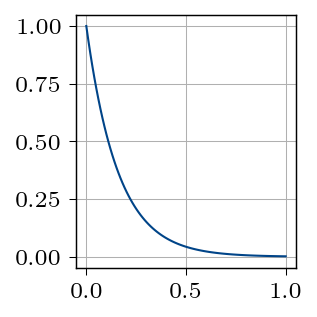

In [104]:
def test(x):
    return np.exp(-2*3.14*x)
x=np.linspace(0,1,100)
fig, ax = plt.subplots(1,1,figsize=(2,2))
ax.plot(x,test(x))

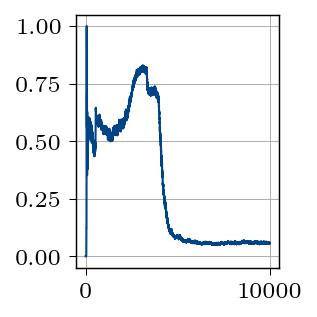

In [105]:
fig, ax = plt.subplots(1,1,figsize=(2,2))
ax.plot(alignment_new_full(0,n,run_name, align_weight=10))

In [106]:
def plot_update_data(M, N, ax, flag=0, prints=True, run_name="run"):
    data = read_update_data(M, N, run_name=run_name)
    if flag==0:
        #plot phi_0
        ax.plot(data["updates"], data["phi_0"], label=fr"($m,n$)=({M},{N})")
        ax.set(xlabel="updates", ylabel="Fitness", yscale='log')
        ax.legend()
        temp = data['phi_0']
        print(f"(m,n)=({M},{N}): Sum of phi_0: {np.sum(temp): .2g}, Phi_0 at last update {temp[-1]} " )
    elif flag==1:
        #plot tasks
        for j in range(len(data["tasks"])):
            ax.plot(data["updates"], data["tasks"][j]/data["n_orgs"], label=f"{operations[j]}")
        ax.legend(ncol=2)
        ax.set(xlabel="updates", ylabel="Fraction of population", title=f"(m,n)=({M},{N})", ylim=[0,1])
        temp=data["tasks"]
        print(f"(m,n)=({M},{N}): Sum of tasks: {np.sum(np.sum(temp,axis=1)): .2g},\n {np.sum(temp,axis=1):}")
    elif flag==2:
        #plot phi_0 sum
        phi_0_cum_sum = [0]
        for i, phi_0_u in enumerate(data["phi_0"]):
            phi_0_cum_sum.append(phi_0_cum_sum[-1] + phi_0_u)
        ax.plot(data["updates"], phi_0_cum_sum[1:], label=fr"($m,n$)=({M},{N})")
        ax.set(xlabel="updates", ylabel=r"Cumulative sum of $\Phi_0$", yscale="log")
        ax.legend()
    elif flag==3:
        #plot alignment
        
        ax.plot(data["updates"], alignment_new_full(M, N, run_name=run_name), label=fr"($m,n$)=({M},{N}) ")
        #ax.plot(data["updates"], alignment(data["phi_0"], data["phi_i"]), label=fr"($m,n$)=({M},{N}) ")
        #ax.plot(data["updates"], data["phi_i"], label=fr"($m,n$)=({M},{N}) phi_agi")
        ax.set(xlabel="updates", ylabel=r"Alignment")
        ax.legend()

In [107]:
def read_meta_data(run_name="run"):

    data = np.genfromtxt(f"./cbuild/work/data/AGIdata/{run_name}/metarun.csv", delimiter=',', skip_header=1)
    m=data[:,0]
    phi_0_max=data[:,1]
    imax=data[:,2]
    chromosome_length = data.shape[1]-3

    hat_phi = np.array([data[:,i] for i in range(3,3+chromosome_length)])
    meta_data = {"m":m, "phi_0_max":phi_0_max, "imax": imax, "chromosome":hat_phi, "chromosome_length":chromosome_length}
    return meta_data

In [108]:
def get_instruction_set():
    configFilePath = 'cbuild/work/instset-heads.cfg'
    f = open(configFilePath, "r")
    inst_set_file = f.read()
    inst_set = [ins.split('#')[0][1:] for ins in inst_set_file.split('INST')[2:]]
    return inst_set

In [109]:
def plot_meta_data(ax, flag=0, task=0, run_name="run"):
    data = read_meta_data(run_name=run_name)
    if flag==0:
        ax.plot(data['m'], data['phi_0_max'])
        ax.set(xlabel='Meta Generation', ylabel=r"Max fitness $\Phi_0$", yscale='log')
    if flag==1:
        ax.plot(data['m'], data['chromosome'][task])
        ax.set(ylabel="chromosome", title=f"Task {task}", xlabel=r'$m$')

In [110]:
def plot_strategy_data(M, N, ax, run_name="run"):
# M=1
# N=0
# run_name="run"
# fig, ax = plt.subplots(1,1)

    data = read_update_data(M, N, run_name=run_name)

    for j in range(len(data["strategy"])):
        ax.plot(data["updates"], data["strategy"][j], label=f"{operations[j]}")
    ax.legend(ncol=2)
    ax.set(xlabel="Update", ylabel="Strategy", title=f"(m,n)=({M},{N})")

In [111]:
def compare_strategies(M=[0,1,2], N=[0,0,0], run_name="run"):
# M=[0,1,2]
# N=[0,0,0]
# run_name="run"

    if len(M) != len(N):
        print("Not same length of N and M")
        #return False

    fig = plt.figure(constrained_layout=True, figsize=(16, 3+len(M)*3))
    gs = GridSpec(len(M), 1, figure=fig)
    axs = []
    for i in range(0, len(M)):
        axs.append(fig.add_subplot(gs[i, :]))

    for i, m, n in zip(range(0, len(M)), M, N):
        plot_strategy_data(m, n, axs[i], run_name=run_name)

In [112]:
def compare_meta_runs(M=[0,1,2], N=[0,0,0], run_name="run", save_fig=[False, "tasks"]):
    if len(M) != len(N):
        print("Not same length of N and M")
        return False
    fig = plt.figure(constrained_layout=True, figsize=(16, 3+len(M)*3))
    gs = GridSpec(len(M)+1, 2, figure=fig)
    axs = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1])]
    for i in range(1,len(M)+1):
        axs.append(fig.add_subplot(gs[i, :]))
    
    for i, m, n in zip(range(2, len(M)+2), M, N):
        plot_update_data(m, n, axs[0], flag=0, prints=True, run_name=run_name)
        plot_update_data(m, n, axs[1], flag=3, prints=True, run_name=run_name)
        plot_update_data(m, n, axs[i], flag=1, prints=True, run_name=run_name)

    if save_fig[0]:
        print("saving figure")
        fig.savefig(f"figures/{save_fig[1]}.pdf")
        

In [113]:
def plot_final_genome(ax, run_name="run", inst_set=False):
    data = read_meta_data(run_name=run_name)
    final_chromosome = np.array([d[-1] for d in data['chromosome']])
    chromosome_length = len(final_chromosome)
    #ops = operations[:chromosome_length]
    if inst_set:
        ax.plot(get_instruction_set(), final_chromosome)
    else:
        ax.plot(final_chromosome)
    ax.set(xlabel="Gene", ylabel="Value", title="Final Chromosome")

In [114]:
def decay(m, decay_rate=0.95, constant=25/3, min_constant=0.5):
    return constant*decay_rate**m + min_constant

In [115]:
def read_settings_data(run_name="run"):
    df = pd.read_csv(f"./cbuild/work/data/AGIdata/{run_name}/settings.csv")
    return df

In [116]:
def produce_meta_report(run_name="run", save_fig=[[False, False, False, False], ["report0", "report1", "report2", "report3"]], inst_set=False):
    print("***** REPORT *****")
    
    print("Settings:")
    df = read_settings_data(run_name=run_name)
    display(df)
    gene_min=df[' gene_min'][0]; gene_max=df[' gene_max'][0]
    chromosome_length = read_meta_data(run_name=run_name)["chromosome_length"]
    
    #fig1, axs = plt.subplots(1,2, figsize=(16,2)
    #plot_edit_distances(axs[0], axs[1], run_name=run_name)

    fig1, axs = plt.subplots(1,1, figsize=(16,2)) 
    plot_meta_data(axs, flag=0, run_name=run_name)

    print("Best fitness per meta generation and the corresponding chromosomes")
    fig2, axs = plt.subplots(7,4, figsize=(16,16))
    genes = [j for j in range(0, int(chromosome_length), 1)]
    ix = 0
    for i in range(7):
        for j in range(4):
            if ix >= int(chromosome_length):
                continue
            plot_meta_data(axs[i,j], flag=1, task=genes[ix], run_name=run_name)
            axs[i,j].set(ylim=[gene_min-0.5, gene_max+0.5])
            ix += 1
    fig2.tight_layout()
    # fig2 = plt.figure(constrained_layout=True, figsize=(16,12))
    # gs = GridSpec(5, 3, figure=fig2)
    # axs = [fig2.add_subplot(gs[0, :])]
    # for i in range(1,4):´
    #     for j in range(3):
    #         axs.append(fig2.add_subplot(gs[i, j]))´
    # axs.append(fig2.add_subplot(gs[1+3,:])    
    
    # plot_meta_data(axs[0], flag=0, run_name=run_name)

    # for task, ax in enumerate(axs[1:1+chromosome_length]):
    #     plot_meta_data(ax, flag=1, task=task, run_name=run_name)
    #     ax.set(ylim=[gene_min-0.5, gene_max+0.5])

    fig3, ax = plt.subplots(1,1, figsize=(16,2))
    plot_final_genome(ax, run_name, inst_set=inst_set)
    fig3.tight_layout()
    plt.xticks(rotation=45)

    fig4, ax = plt.subplots(1,1, figsize=(16,2))
    plot_chromosome_convergence(ax, run_name)

    figs = [fig1, fig2, fig3, fig4]

    for i, sf in enumerate(save_fig[0]):
        if sf:
            figs[i].savefig(f"figures/{save_fig[1][i]}.pdf")
 

In [205]:
runs

['run_n025_b025', 'run_n025_b025']

In [117]:
data3=data[3]
for chromosome, alignment, useful, Id in zip(data3['chromosomes'], data3["alignment"].transpose(), data3["useful"].transpose(), data3['(m,n)'].transpose()):
    for a, u, id in zip(alignment, useful, Id):
        #print(a)
        if u >= 3:
            if a>0.95 or a < 0.25:
                print(f"Alignment = {round(a,3)}, for {chromosome}, at {id} ")

KeyError: 3

[1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1.]
(m,n)=(0,0): Sum of phi_0:  1.3e+06, Phi_0 at last update 139.805479 
(m,n)=(0,0): Sum of tasks:  8.8e+07,
 [31006005. 29697756. 27672495.]
(m,n)=(0,367): Sum of phi_0:  7.9e+05, Phi_0 at last update 119.128301 
(m,n)=(0,367): Sum of tasks:  7.3e+07,
 [32097480. 21711234. 19387320.]


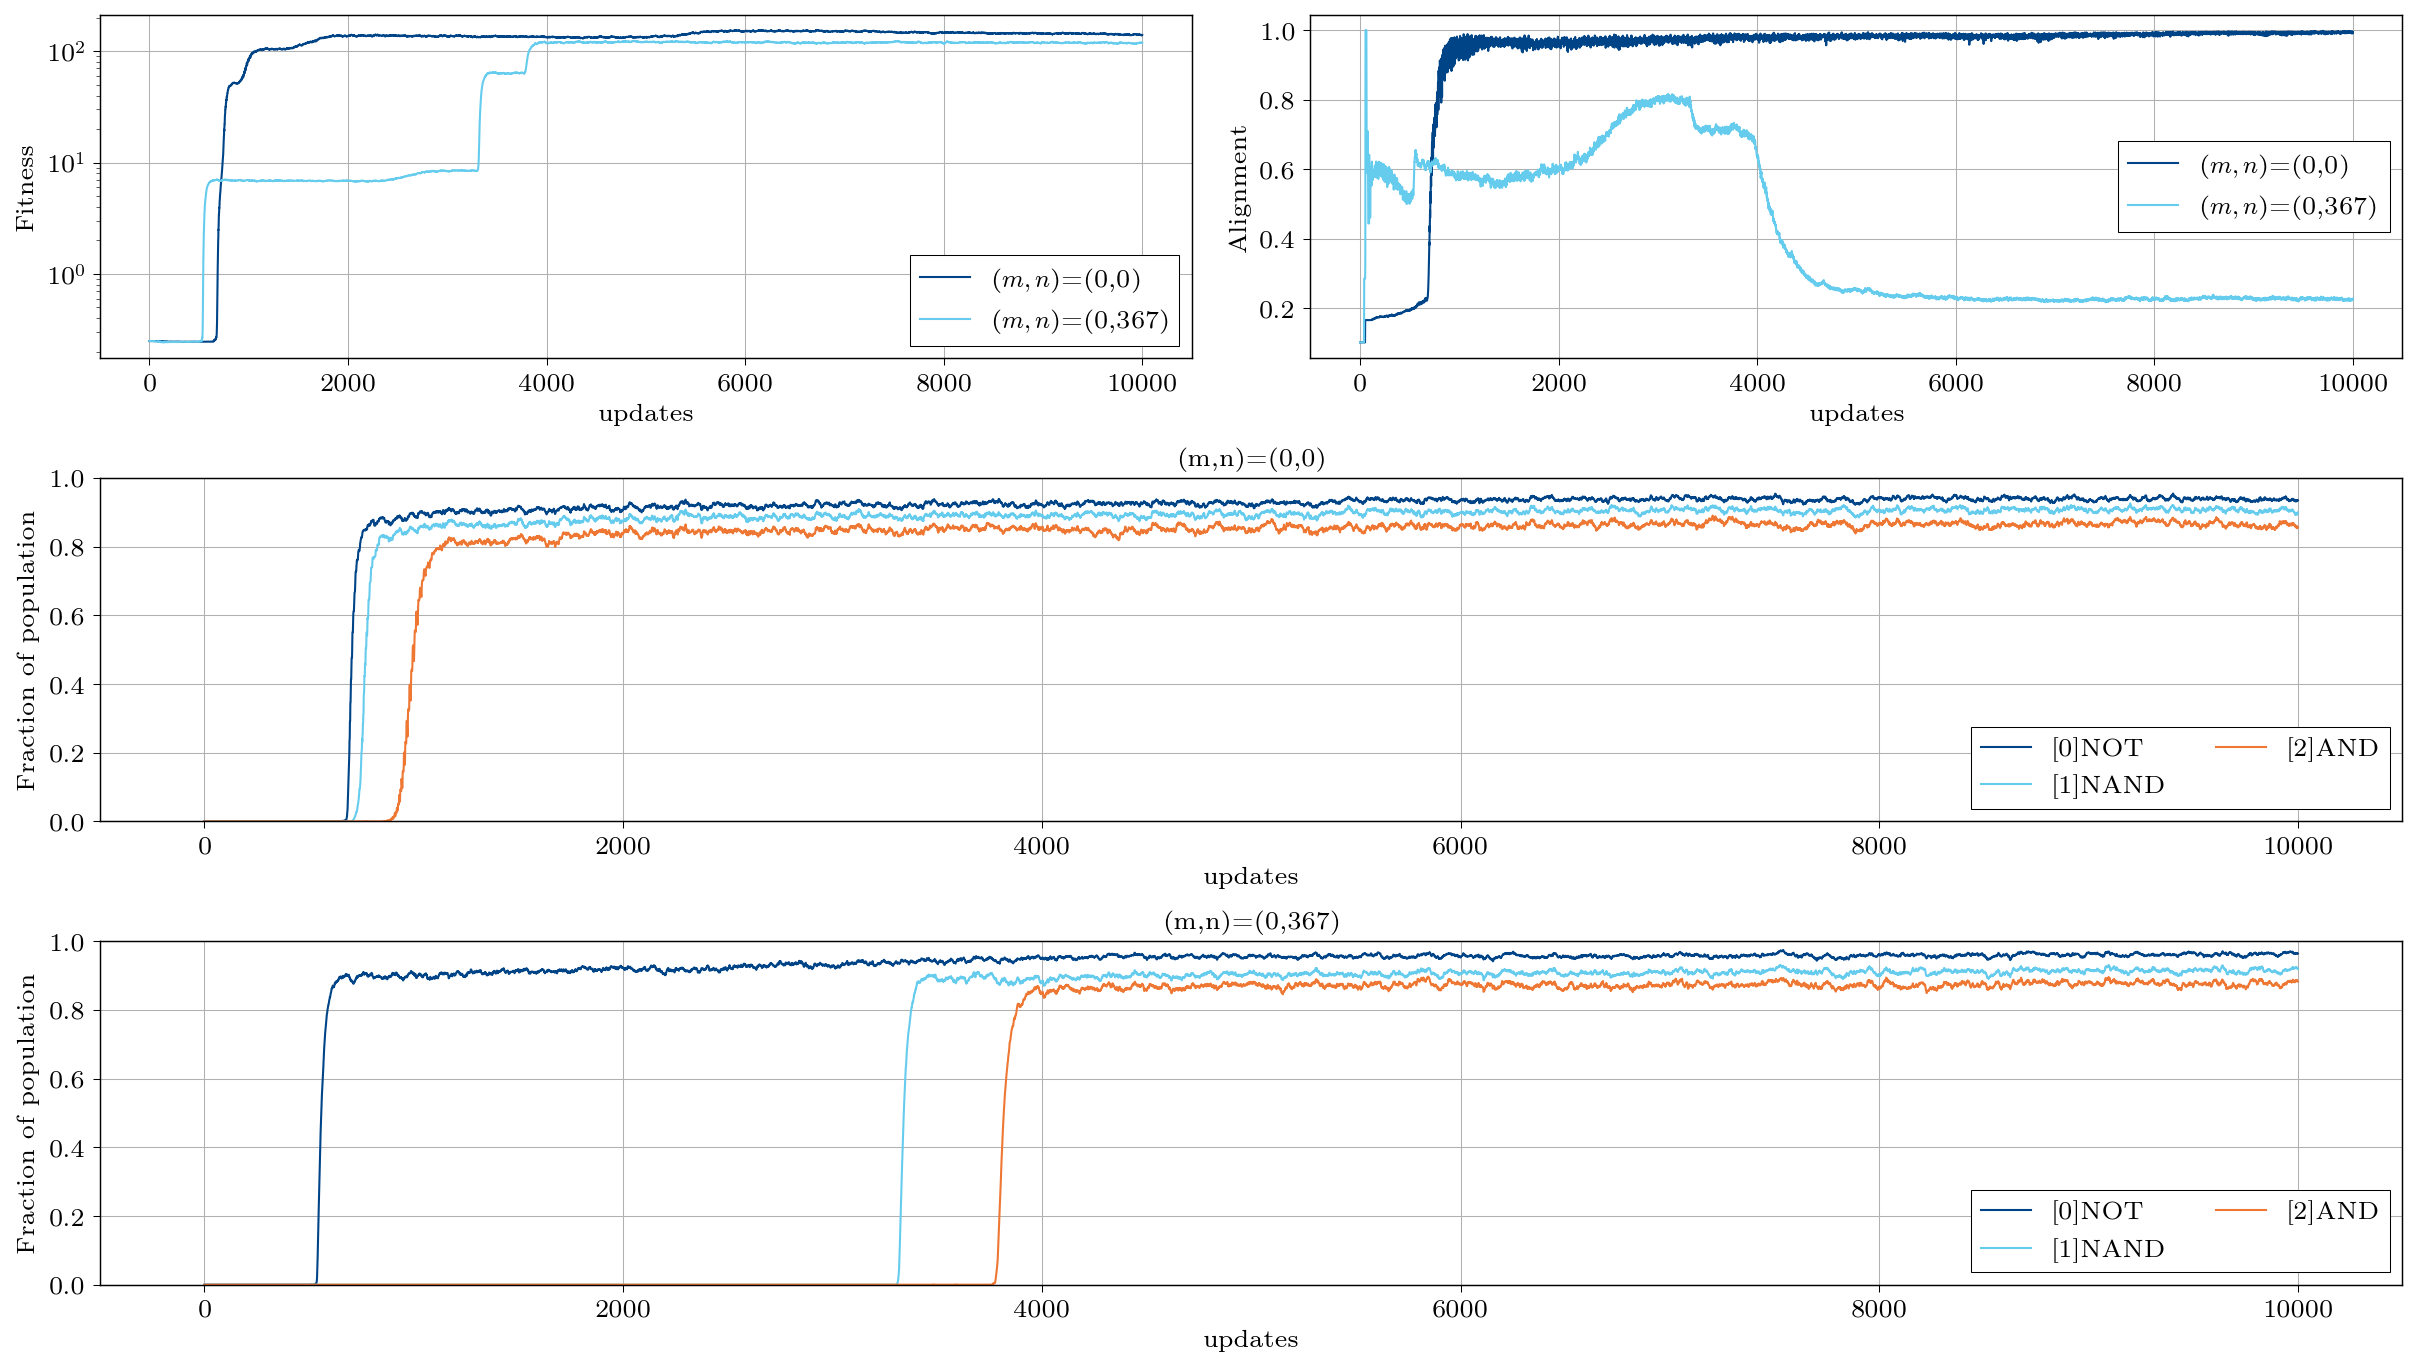

In [206]:
run_name = 'run_n025_b025'
#N = [i for i in [408,416,424]]
#N = [0,179,430]
N = [0,367]
M = [0 for i in range(len(N))]

runs=[run_name for i in range(len(N))]
for r,m,n,a in zip(runs, M, N, range(len(N))):
    d = read_update_data(m,n, f"{r}")
    print(d['strategy'].transpose()[0])

#produce_meta_report(run_name=run_name, save_fig=[[False, False, False, False], ["report011b", "report1", "report2", "report3"]], inst_set=False)
compare_meta_runs(M=M, N=N, run_name=run_name) #, save_fig=[True, "tasks_02_25"])
#compare_strategies(M=M, N=N, run_name=run_name)

In [23]:
alignment_new_full(m, n, run_name=run_name)

array([3.69230769, 3.69230769, 3.69230769, ..., 1.40041924, 1.39989232,
       1.39362569])

In [118]:
def pt_to_inch(pt):
    return 72*pt

'lmroman7-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'lmroman7-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
[1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1.]
'lmroman7-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


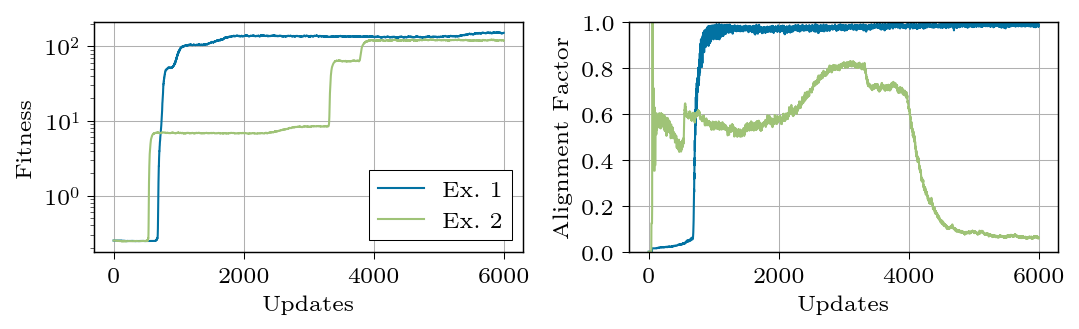

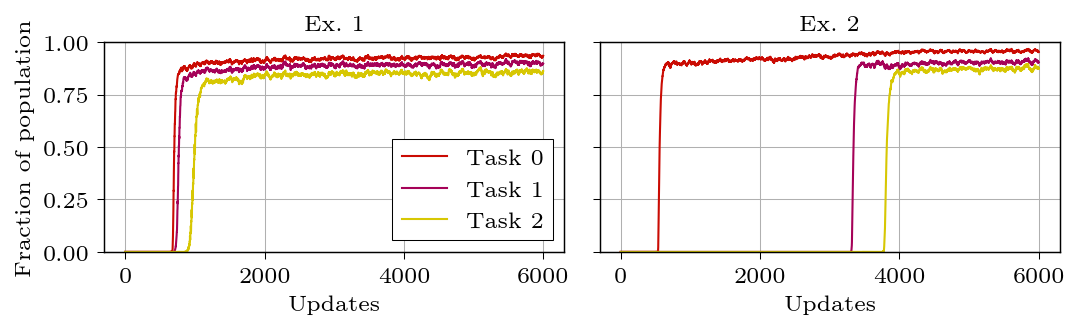

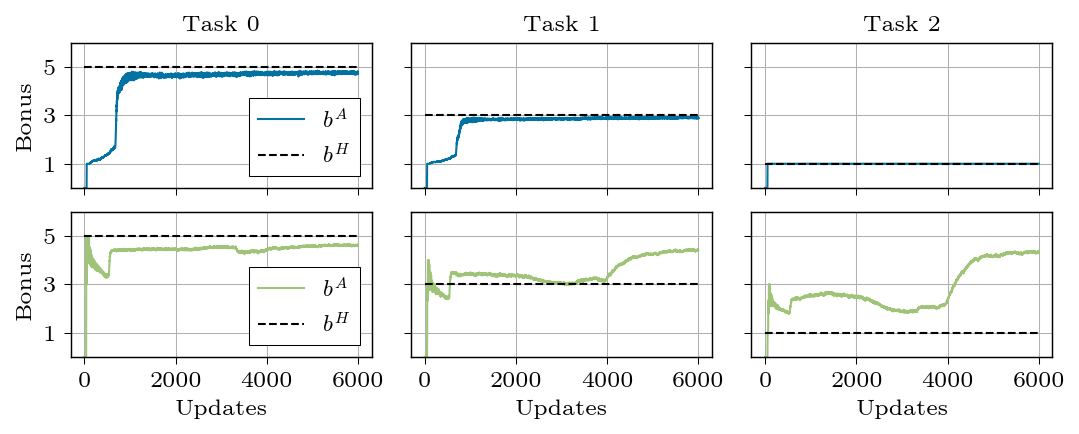

In [147]:
# Plot for report
pt=1/72
from cycler import cycler
ex1='#0272a2'; ex2='#9fc377';
plt.rcParams['axes.prop_cycle'] = cycler(color=[ex1,ex2])
#fitness
fig, axs = plt.subplots(1,2, figsize=(510*pt,150*pt))
run_name = 'run_n025_b025'
runs=[run_name for i in range(len(N))]
M=[0,0]
N=[0,367]
labels = ['Ex. 1', 'Ex. 2']
stop = 6000
for m,n,label in zip(M,N,labels):
    data = read_update_data(m, n, run_name=run_name)
    ax=axs[0]
    ax.plot(data["updates"][0:stop], data["phi_0"][0:stop], label=label)
    ax.set(xlabel='Updates',ylabel="Fitness", yscale='log')

    ax=axs[1]
    ax.plot(data["updates"][0:stop], alignment_new_full(m, n, run_name=run_name)[0:stop], label=fr"($m,n$)=({M},{N}) ")
    ax.set(xlabel="Updates", ylabel="Alignment Factor", ylim=[0,1])
axs[0].legend()
fig.savefig(f"figures/reporttest1.pdf")
#tasks
plt.rcParams['axes.prop_cycle'] = cycler(color=[ '#ca0b03', '#a50258', '#d7c703', '#88cada'])
fig, axs = plt.subplots(1,2,sharey=True,figsize=(510*pt,150*pt))
for m,n,ax in zip(M,N,axs):
    data = read_update_data(m, n, run_name=run_name)
    for j in range(len(data["tasks"][0:stop])):
        ax.plot(data["updates"][0:stop], data["tasks"][j][0:stop]/data["n_orgs"][0:stop], label=f"Task {j}")
    
    ax.set(xlabel="Updates", ylim=[0,1])
axs[0].legend(ncol=1)
axs[0].set(ylabel="Fraction of population", title=labels[0])
axs[1].set(title=labels[1])
fig.savefig(f"figures/reporttest2.pdf")
    #temp=data["tasks"]
    

#bonus
#plt.rcParams['axes.prop_cycle'] = cycler(color=['#DBDBDB', '#DCD5CC', '#DCCEBE', '#DDC8AF', '#DEC2A0', '#DEBB91'])
b_H = [5,3,1]
fig, axs = plt.subplots(2,3, figsize=(510*pt,200*pt), sharex=True, sharey=True)
#runs=[runs[0] for i in range(3)]
title=["Bonus", 'Bonus']
for r,m,n,a in zip(runs, M, N, range(len(N))):
    d = read_update_data(m,n, f"{r}")
    print(d['strategy'].transpose()[0])
    for i, ax in enumerate(axs[a]):
        if a==0:
            color=ex1
        else:
            color=ex2
        ax.plot(d["bonus_mean"][i][:stop], color=color, label=r'$b^{A}$')
        #ax.plot(d["bonus_mean"][i] + np.sqrt(d["bonus_var"][i]), 'g', label=r'$b_{AGI}$ std')
        #ax.plot(d["bonus_mean"][i] - np.sqrt(d["bonus_var"][i]), 'g', label=r'$b_{AGI}$ std')
        ax.plot([0, len(d['bonus_mean'][i][:stop])],[b_H[i], b_H[i]], '--k', label=r'$b^H$')
        ax.set(ylim=[0,6], yticks=[1,3,5])
        if i==0:
            ax.set( ylabel=title[a])
        if i==0:
            ax.legend(ncol=1, loc='lower right')
        if a==0:
            ax.set(title=f"Task {i}")
        if a==1:
            ax.set(xlabel='Updates')
fig.savefig(f"figures/reporttest3.pdf")

[1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1.]


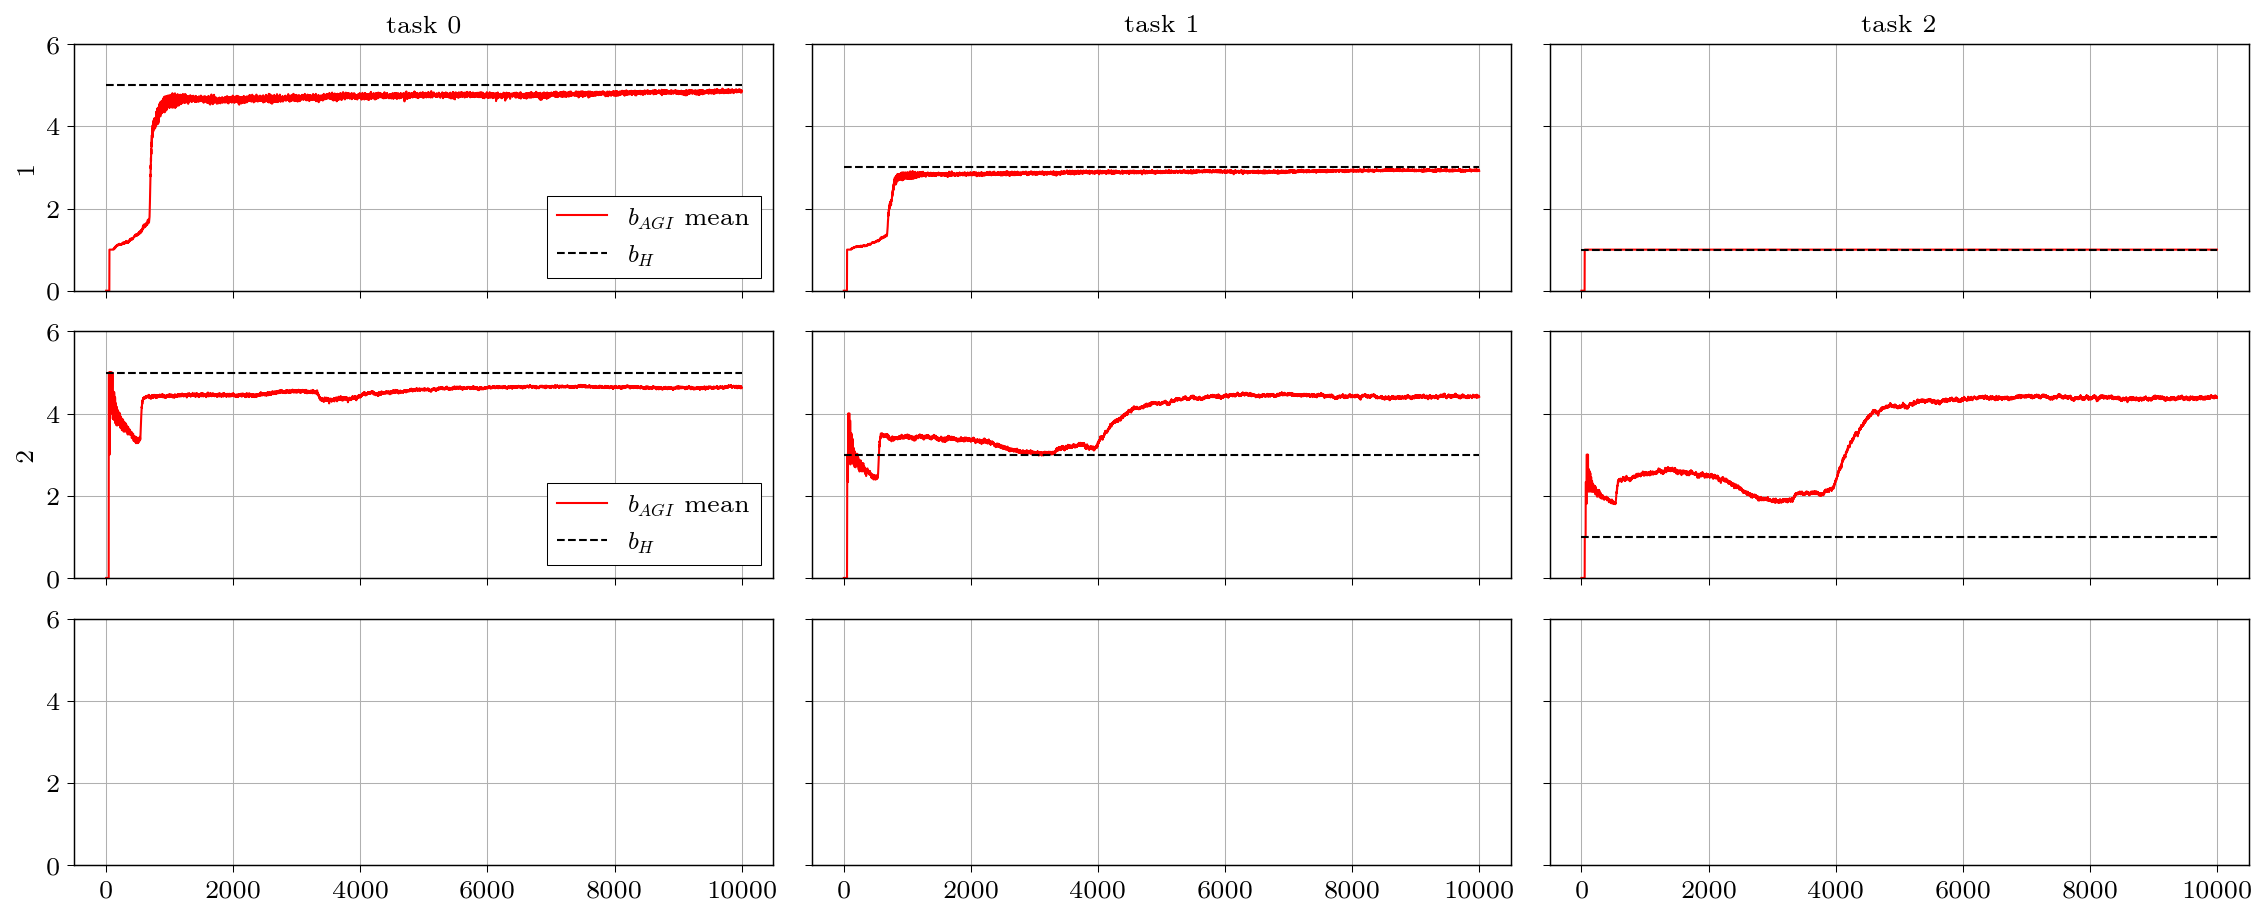

In [169]:
b_H = [5,3,1]
fig, axs = plt.subplots(3,3, figsize=(15,6), sharex=True, sharey=True)
N = [0,367, 0]
M = [0 for i in range(len(N))]
#runs=[runs[0] for i in range(3)]
title=["1", '2', '3']
for r,m,n,a in zip(runs, M, N, range(len(N))):
    d = read_update_data(m,n, f"{r}")
    print(d['strategy'].transpose()[0])
    for i, ax in enumerate(axs[a]):
        ax.plot(d["bonus_mean"][i], 'r', label=r'$b_{AGI}$ mean')
        #ax.plot(d["bonus_mean"][i] + np.sqrt(d["bonus_var"][i]), 'g', label=r'$b_{AGI}$ std')
        #ax.plot(d["bonus_mean"][i] - np.sqrt(d["bonus_var"][i]), 'g', label=r'$b_{AGI}$ std')
        ax.plot([0, len(d['bonus_mean'][i])],[b_H[i], b_H[i]], '--k', label=r'$b_H$')
        ax.set(ylim=[0,6])
        if i==0:
            ax.legend()
            ax.set( ylabel=title[a])
        if a==0:
            ax.set(title=f"task {i}")
        if a==1:
            ax.set(xlabel='Updates')
#fig.savefig(f"figures/bonus_mean.pdf")

In [24]:
def plot_good_agi(data, rows=4, cols=4, save_fig=[False, 'Alignment_useful']):
    fig, axs = plt.subplots(rows,cols, figsize=(20,16), sharex=True, sharey=True)
    ax_vec = axs.reshape(-1)
    j=0
    x_min=0.8; x_max=1.0; y_min=2; y_max=3.0;
    for i, ax in enumerate(ax_vec):
        ax.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], 'r--', label='Good AGI')
        #while (np.sum(data['chromosomes'][i+j][0:2]) < 2 ):
        #    j+=1
        ax.plot(data['alignment'][:,i+j],data['useful'][:,i+j],'o', label='Seeds')
        ax.set(title=f"Chromosome = {data['chromosomes'][i+j]}", ylim=[-0.5,3.5], xlim=[0,1.05], )
        if i%rows==0:
            ax.set(ylabel="Usefulness (#Tasks completed)")
        if i>=cols*(rows-1):
            ax.set(xlabel="Alignment factor")
        #ax.grid()
        ax.legend()
    if save_fig[0]:
        fig.savefig(f"figures/{save_fig[1]}.pdf")

In [25]:
#plot_good_agi(data3, save_fig=[False, 'alignment_greedy'])

In [26]:
def get_count_fraction_goodagi(data, useful_lim=2, alignment_lim=0.8, num_instructions=36, do_print=True):
    
    #counts = np.zeros(num_instructions)
    tot_good_AGI = 0
    classes = [np.zeros(n) for n in [3,3,4,4,3]]
    switcher = {
            0: np.array([1,0,0]),
            1: np.array([0,1,0]),
            2: np.array([0,0,1]),
            3: np.array([1,0,0]),
            4: np.array([0,1,0]),
            5: np.array([0,0,1]),
            7: np.array([1,0,0]),
            8: np.array([0,1,0]),
            9: np.array([0,0,1]),
            
        }
    switcher2 = {6: np.array([1,0,0,0]),
                3: np.array([0,1,0,0]),
                4: np.array([0,0,1,0]),
                5: np.array([0,0,0,1]),

    }

    perms = {'2':[0,1,2], '3':[3,4,5], '4': [6,3,4,5], '5':[7,8,9]}

    for chromosome, alignment, useful in zip(data['chromosomes'], data["alignment"].transpose(), data["useful"].transpose()):
        for a, u in zip(alignment, useful):
            
            if a >= alignment_lim and u >= useful_lim:
                tot_good_AGI +=1
                
                #print(chromosome)
                for inst_class, gene in enumerate(chromosome):
                    #print(f"gene = {gene}, class = {inst_class}")

                    if inst_class == 2 or inst_class == 3:
                        classes[inst_class] += switcher2[gene]
                    else:
                        classes[inst_class] += switcher[gene]
                
                    
    if do_print:               
        print(tot_good_AGI)
    if tot_good_AGI == 0:
        tot_good_AGI=1
        
    return np.array([np.array(c)/tot_good_AGI for c in classes])


In [27]:
def mean_std_alignment(data, min_lim=0.6, max_lim=1.0, num_classes=5, useful_lim=3):
    mean_classes = [[] for i in range(5)]
    std_classes = [[] for i in range(5)]#[np.zeros(n) for n in [3,3,4,4,3]]
    #temp_classes = [np.zeros(n) for n in [3,3,4,4,3]]
    lims = np.linspace(min_lim, max_lim, num_classes)

    for lim_i, lim in enumerate(lims):
        #print(lim)
        classes = get_count_fraction_goodagi(data, useful_lim=useful_lim, alignment_lim=lim, do_print=False)
        if lim_i==0:
            temp_classes=classes
        else:
            for i, c in enumerate(classes):
                temp_classes[i] = np.c_[temp_classes[i], c]
        #for c in classes:
            #temp_classes
    #print(temp_classes)
    for i, c in enumerate(temp_classes):
        #print(c)
        mean_classes[i] = np.array([np.mean(t) for t in c])
        std_classes[i] = np.array([np.std(t) for t in c])
    
    return mean_classes, std_classes
    


In [28]:
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color='brgcmyk')

In [29]:
titles = ['Initialize Opinion', 'Human Communication', 'Agent Communication - Tell', 'Agent Communication - Ask', 'Self Interaction']
def plot_av_std_classes(axs, Mean, Std, label):
    for ax, mean, std, title in zip(axs, Mean, Std, titles):
        ax.errorbar(np.linspace(0,len(mean)-1,len(mean)), mean, yerr=std, marker='o', markersize=5, capsize=5, label=label)
        ax.set(ylim=[0,1.05], xticks = list(np.linspace(0,len(mean)-1,len(mean))), xlabel="Instruction", title=title)
    axs[0].set(ylabel="Fractional occurance in Good AGI")
    axs[0].legend()

In [38]:
runs = ['run_n05_b01', 'run_n025_b01', 'run_n01_b01', 'run_n01_b025']
data = []
for run in runs:
    print(run)
    data.append(create_useful_alignemnt_data(432,1, run_name=run))

run_n01_b025
0
432 chromosomes and 432 worlds


<ipython-input-26-2aaa1e6ee3ce>:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([np.array(c)/tot_good_AGI for c in classes])
'lmroman7-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
<ipython-input-26-2aaa1e6ee3ce>:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([np.array(c)/tot_good_AGI for c in classes])


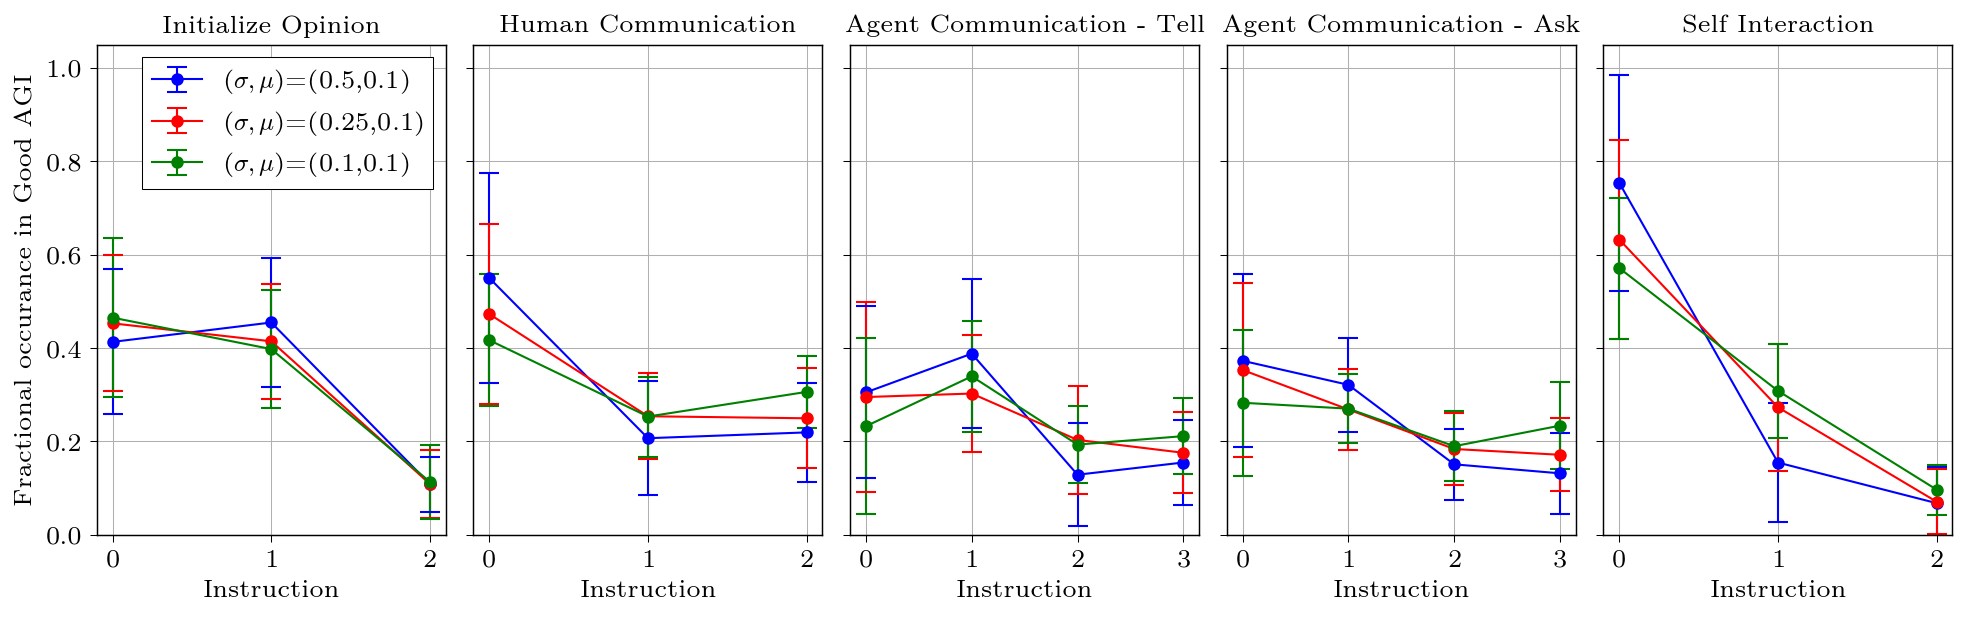

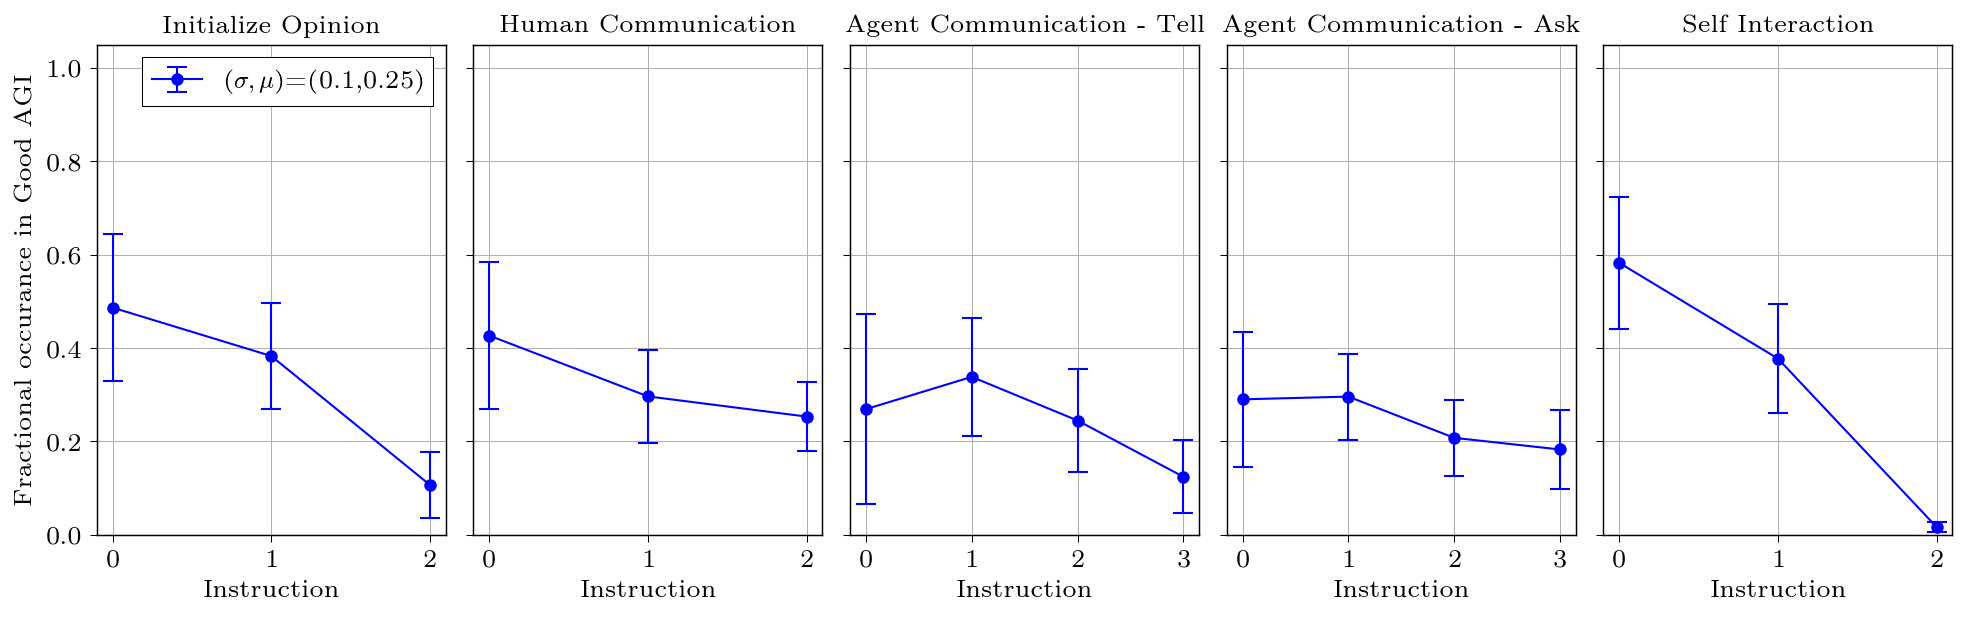

In [45]:
fig, axs = plt.subplots(1,5, figsize=(13,4), sharey=True)
noise_bias = [(0.5,0.1), (0.25,0.1), (0.1,0.1), (0.1,0.25)]
for dat, label, nb in zip(data, labels, noise_bias):
    if nb[1]==0.1:
        Mean, Std = mean_std_alignment(dat, min_lim=0.6, max_lim=1.0, num_classes=41)
        plot_av_std_classes(axs, Mean, Std, label=rf'($\sigma,\mu$)=({nb[0]},{nb[1]})')
fig.savefig(f"figures/{'instruction_distribution_meating10'}.pdf")
fig, axs = plt.subplots(1,5, figsize=(13,4), sharey=True)
for dat, label, nb in zip(data, labels, noise_bias):
    if nb[1]==0.25:
        Mean, Std = mean_std_alignment(dat, min_lim=0.6, max_lim=1.0, num_classes=41)
        plot_av_std_classes(axs, Mean, Std, label=rf'($\sigma,\mu$)=({nb[0]},{nb[1]})')



#fig.savefig(f"figures/{'instruction_distribution'}.pdf")

In [84]:
1/(1+3*(0.5**2)/4)

0.8421052631578947

In [83]:
0.25**2

0.0625

<ipython-input-27-2aaa1e6ee3ce>:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([np.array(c)/tot_good_AGI for c in classes])


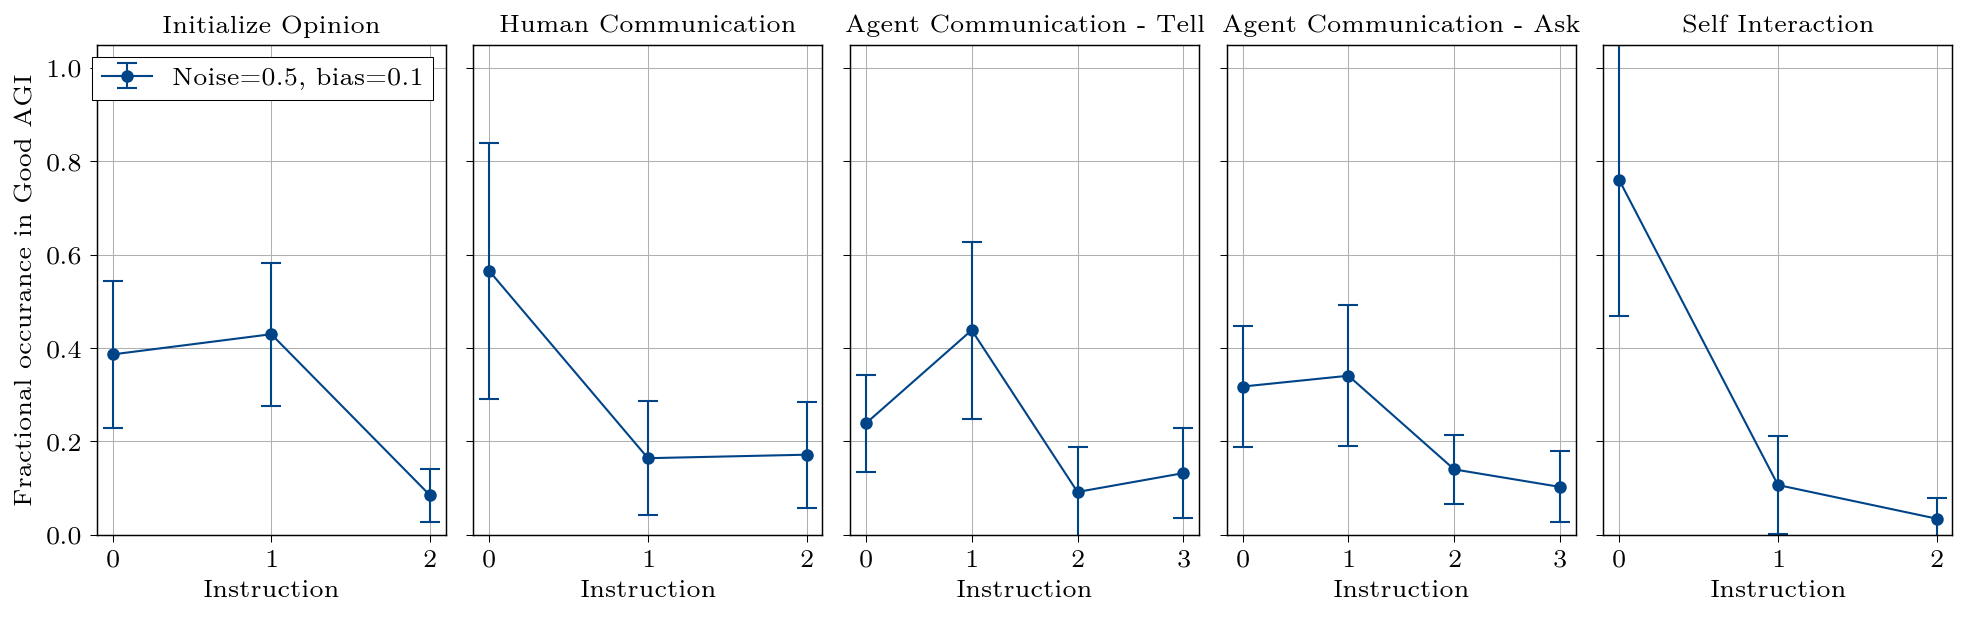

In [99]:
fig, axs = plt.subplots(1,5, figsize=(13,4), sharey=True)
#Mean, Std = mean_std_alignment(data, min_lim=0.6, max_lim=1.0, num_classes=41)
#plot_av_std_classes(axs, Mean, Std, label='Noise=0.5, bias=0.1')
#Mean, Std = mean_std_alignment(data2, min_lim=0.73, max_lim=1.0, num_classes=10)
#plot_av_std_classes(axs, Mean, Std, label='Noise=0.25, bias=0.25')
Mean, Std = mean_std_alignment(data3, min_lim=0.7, max_lim=1.0, num_classes=10)
plot_av_std_classes(axs, Mean, Std, label='Noise=0.5, bias=0.1')


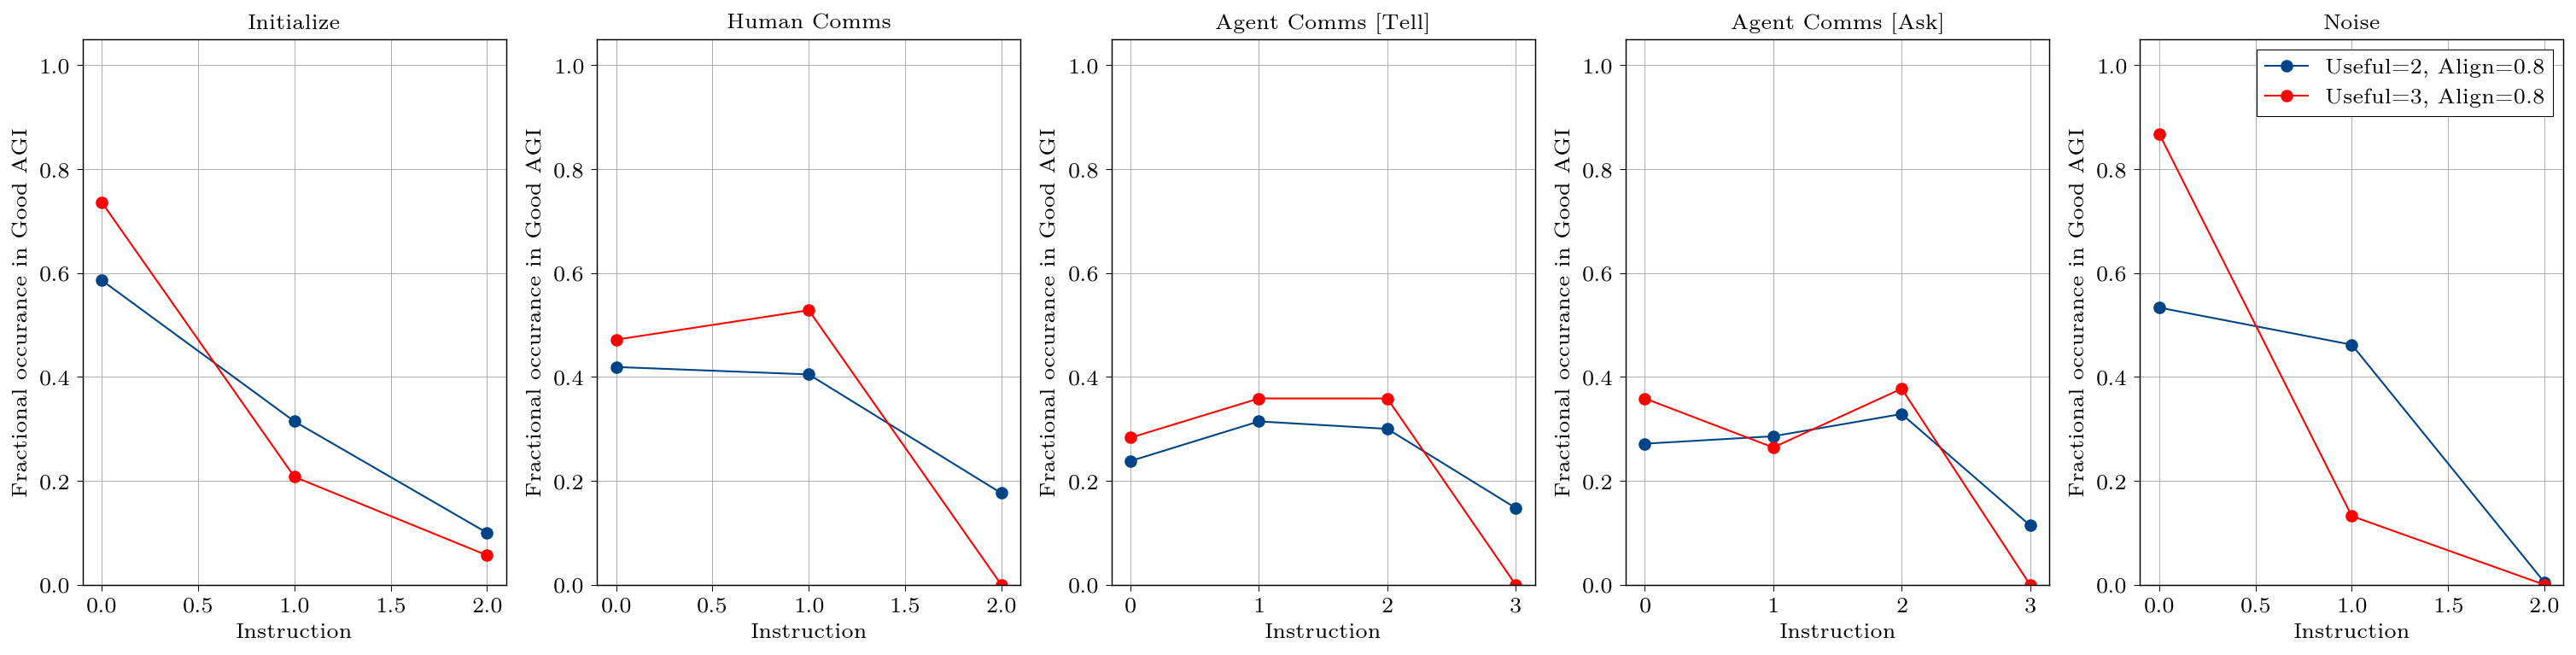

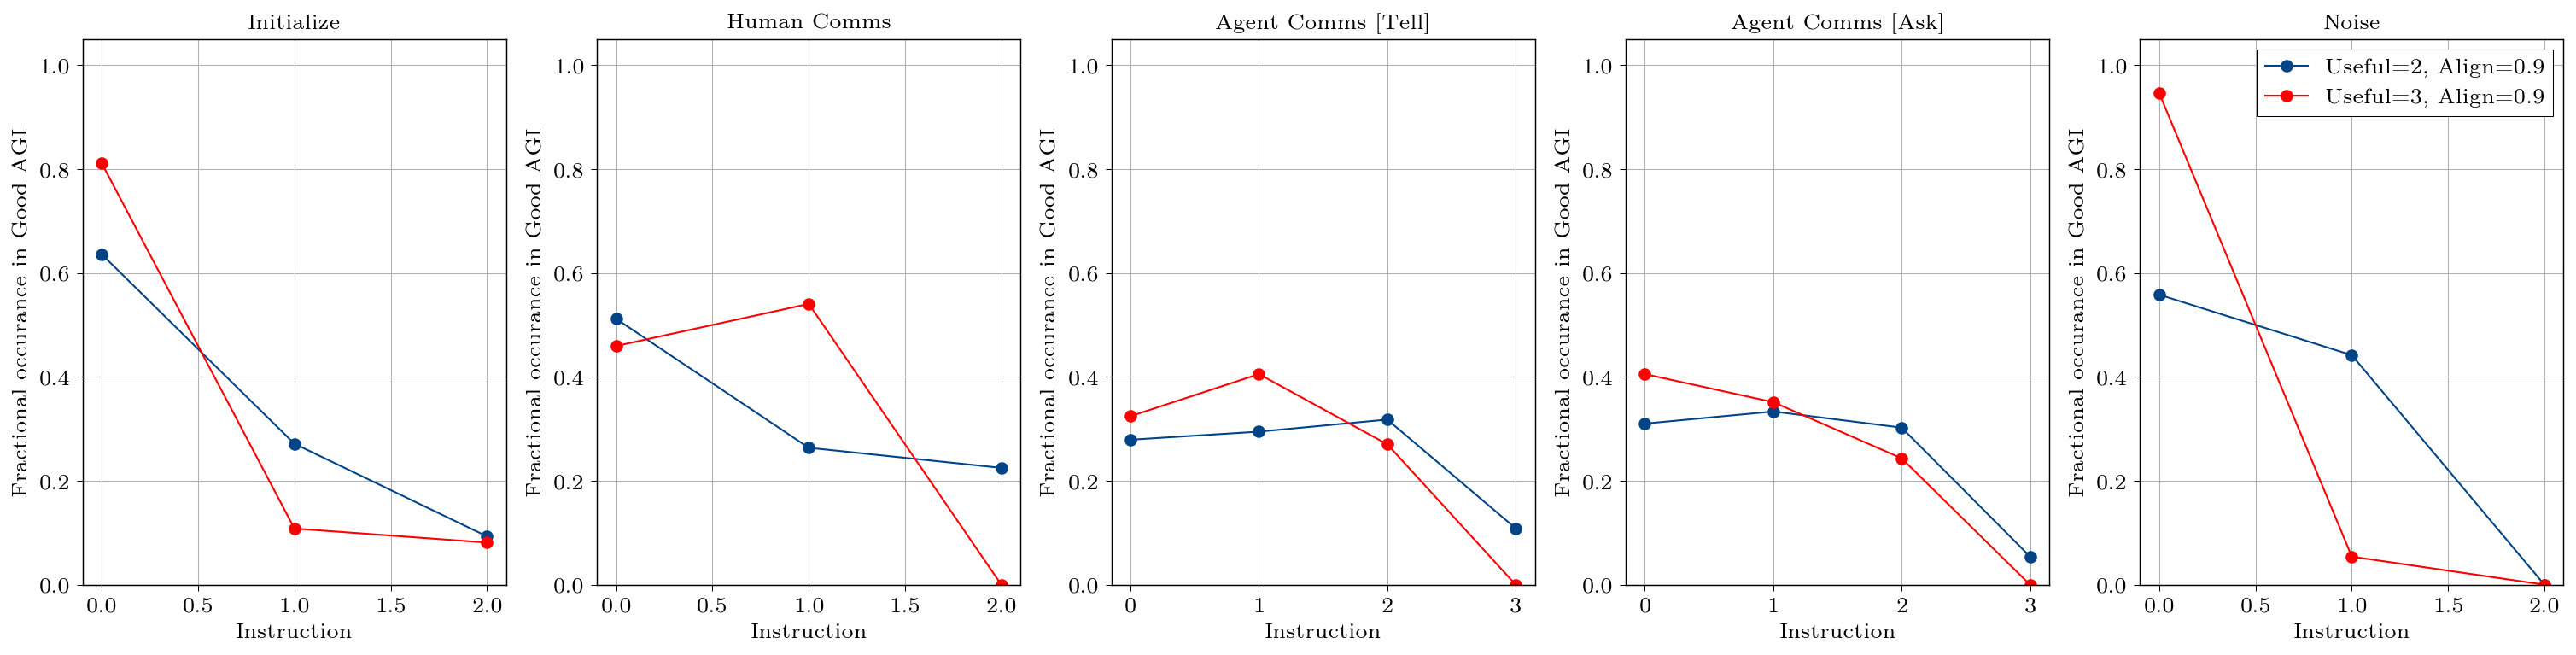

In [59]:
fig, axs = plt.subplots(1,5, figsize=(20,5))
titles = ['Initialize', 'Human Comms', 'Agent Comms [Tell]', 'Agent Comms [Ask]', 'Noise']
for ax, count, title in zip(axs, classes1, titles):
    ax.plot(count, '-o', label="Useful=2, Align=0.8")

    ax.set(ylim=[0,1.05], ylabel="Fractional occurance in Good AGI", xlabel="Instruction", title=title)
for ax, count, title in zip(axs, classes2, titles):
    ax.plot(count, 'r-o', label="Useful=3, Align=0.8")
ax.legend()
#fig.savefig(f"figures/{'instruction_distribution'}.pdf")

fig, axs = plt.subplots(1,5, figsize=(20,5))
titles = ['Initialize', 'Human Comms', 'Agent Comms [Tell]', 'Agent Comms [Ask]', 'Noise']
for ax, count, title in zip(axs, classes3, titles):
    ax.plot(count, '-o', label="Useful=2, Align=0.9")

    ax.set(ylim=[0,1.05], ylabel="Fractional occurance in Good AGI", xlabel="Instruction", title=title)
for ax, count, title in zip(axs, classes4, titles):
    ax.plot(count, 'r-o', label="Useful=3, Align=0.9")
ax.legend()



In [ ]:
tot_diff_level = []
for chromosome in data['chromosomes']:
    tot_diff_level.append(0)
    for i, b in enumerate(range(0,15,3)):
        c = chromosome[b:b+3]
        if i == 0 or i==1:
            if np.all(c == np.array([1.0,0.0,0.0])):
                tot_diff_level[-1] += 0
            elif np.all(c == np.array([0.0,1.0,0.0])):
                tot_diff_level[-1] += 1
            else:
                tot_diff_level[-1] += 2

        else:
  
            if np.all(c == np.array([0.0,0.0,0.0])):
                tot_diff_level[-1] += 0
            elif np.all(c == np.array([1.0,0.0,0.0])):
                tot_diff_level[-1] += 1
            elif np.all(c == np.array([0.0,0.0,1.0])):
                tot_diff_level[-1] += 2
            else:
                tot_diff_level[-1] += 3


In [ ]:
m=5
diff_level_norm = [sum(np.array(diff_level)==i)/(m*sum(np.array(tot_diff_level)==i)) for i in range(max(tot_diff_level))]
fig, ax = plt.subplots(1,1)
ax.plot(diff_level_norm)
ax.set(xlabel='Combined difficult level', ylabel='Fraction of Good AGI')

In [ ]:
def class_wise_distribution(class_N=0,num_instructions=15,alignment_lim=0.8,useful_lim=2):
    counts = np.zeros(num_instructions)
    nums = [3,3,4,4,4]
    tot_good_AGI = 0
    class_dist = [[list(np.zeros(n)) for n in nums] for i in nums]
    #class_dist_diff = [[] for i in range(nums[class_N])]
    #print(class_dist)
    class_i = 0
    for chromosome, alignment, useful in zip(data['chromosomes'], data["alignment"].transpose(), data["useful"].transpose()):
        for a, u in zip(alignment, useful):
            
            if a >= alignment_lim and u >= useful_lim:
                tot_good_AGI +=1
                diff_level = 0
                #class_i=-1
                for i, b in enumerate(range(0,15,3)):
                    c = chromosome[b:b+3]
                    if i == class_N:
                        if np.all(c == np.array([1.0,0.0,0.0])):
                            class_i = 0
                        elif np.all(c == np.array([0.0,1.0,0.0])):
                            class_i = 1
                        elif np.all(c == np.array([0.0,0.0,1.0])):
                            class_i = 2
                        else:
                            class_i = 3
                        #print(f"class_i = {class_i} and c = {c}")

                for i, b in enumerate(range(0,15,3)):
                    c = chromosome[b:b+3]
                    if (i == 0 or i==1):# and class_N != i:
                        class_dist[class_i][i] += c
                        #if np.all(c == np.array([1.0,0.0,0.0])):
                        #    diff_level += 0
                        #elif np.all(c == np.array([0.0,1.0,0.0])):
                        #    diff_level += 1
                        #else:
                        #    diff_level += 2

                    else:
                        if np.all(c == np.array([0.0,0.0,0.0])):
                            class_dist[class_i][i][0]+=1
                        else:
                            class_dist[class_i][i][1:] +=c
                        
                        #if np.all(c == np.array([0.0,0.0,0.0])):
                         #   diff_level += 0
                        #elif np.all(c == np.array([1.0,0.0,0.0])):
                        #    diff_level += 1
                        #elif np.all(c == np.array([0.0,0.0,1.0])):
                        #    diff_level += 2
                        #else:
                        #    diff_level += 3
                    #else:
                     #   print('error')

                #class_dist[class_i] += class_dist_temp
                #class_dist_diff[class_i].append(diff_level)

    return class_dist

 

In [ ]:
fig, axs = plt.subplots(5,5, figsize=(25,25))
#axs = axs.reshape(-1)
for c in range(2):
    
    labels=['Difficulty 1', 'Difficulty 2', 'Difficulty 3']

    class_dist = class_wise_distribution(class_N=c)

    for i in range(3):
        classes=class_dist[i]
        titles = ['Initialize', 'Human Comms', 'Agent Comms [Tell]', 'Agent Comms [Ask]', 'Noise']
        for ax, count, title, in zip(axs[c], classes, titles):
            ax.plot(np.array(count)/tot_good_AGI, '-o', )

            ax.set(ylim=[0,1.05], ylabel="Fractional occurance in Good AGI", xlabel="Instruction [difficulty]", title=title)
        #ax.legend()


for c in range(2,5):
    #print(c)
    #fig, axs = plt.subplots(1,5, figsize=(20,5))
    labels=['Difficulty 1', 'Difficulty 2', 'Difficulty 3', 'Difficulty 4']

    class_dist = class_wise_distribution(class_N=c)
    #print(len(class_dist))
    for i in range(4):
        classes=class_dist[i]
        titles = ['Initialize', 'Human Comms', 'Agent Comms [Tell]', 'Agent Comms [Ask]', 'Noise']
        for ax, count, title, in zip(axs[c], classes, titles):
            ax.plot(np.array(count)/tot_good_AGI, '-o',)

            ax.set(ylim=[0,1.05], ylabel="Fractional occurance in Good AGI", xlabel="Instruction [difficulty]", title=title)
        #ax.legend()
fig.savefig(f"figures/{'instruction_distribution_class_wise'}.pdf")

In [3]:
import numpy as np

In [20]:
# Create chromosome file
switcher = {
        0: '0,0,0,',
        1: '1,0,0,',
        2: '0,1,0,',
        3: '0,0,1,',
    }

def chromo(comb):
    chromosome = ""
    for entry in comb:
        chromosome += switcher[entry]
    chromosome+='\n'
    return chromosome

n_classes = 5
perms = {'2':[0,1,2], '3':[3,4,5], '4': [6,3,4,5], '5':[7,8,9]}
combinations = np.array(np.meshgrid(perms['2'], perms['3'], perms['4'], perms['4'], perms['5'])).T.reshape(-1,n_classes)


In [21]:
for c in combinations[0:4]:
    print(f"{c[0]},{c[1]},{c[2]},{c[3]},{c[4]}")

0,3,6,6,7
0,4,6,6,7
0,5,6,6,7
1,3,6,6,7


In [23]:
file = open("cbuild/work/chromosomes.csv","w")
for c in combinations:
    #print(c)
    file.write(f"{c[0]},{c[1]},{c[2]},{c[3]},{c[4]},\n")
    #chromosomes.append(chromo(t))
file.close()

In [132]:
len(combinations)

432

In [19]:
chromosomes = []
i = 0
for c in combinations:
    i+=1
    chromosomes.append(chromo(c))
print(f"{i} Possible Chromosomes. \nExample:")
print(chromosomes[0])

KeyError: 6

In [18]:
file = open("cbuild/work/chromosomes.csv","w")
N=576
for c in chromosomes[:N]:
    #print(c)
    file.write(c)
    #chromosomes.append(chromo(t))
file.close()

In [24]:
3*3*4*4*4

576